In [2]:
!pip install -q matplotlib torch-summary tensorboard

In [3]:
%matplotlib inline


# Training a Classifier

This notebook is a first attempt to training a model on images of 10 classes from CIFAR10 dataset using PyTorch.
We will be using a pre-defined Neural Network from Torchvision library of models to start with.

## What about data?

The data pipelines has 3 steps:
1. Read image file from disk as numpy arrays -- (use Pillow library or Torchvision for preprocessed datasets with PIL images) 
2. Transform:
    - Standardize the format of all images e.g. crop, resize, normalize etc
    - convert numpy arrays to Tensors
3. Batch multiple images together as input (and load in GPU memory if using GPU)

For steps 1 to 3, PyTorch provides a convinient class called Dataloader.
It support different input formats like image, videos and text, you can create a custom dataloader 
using this class and still benefit from the utility functions of the class.


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

An AI framework provides library functions to implement the above steps. 
We are using PyTorch in our case but you can use any -- Tensorflow, Keras, MXNet, etc...  


#### THIS NOTEBOOK IS ADAPTED FROM https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar10 

In [4]:
# Funcitons for capturing time elapsed
import time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_max_memory_allocated()
        torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

In [5]:
import torch, datetime
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# import and instantiate tensorboard for monitoring model performance
from torch.utils.tensorboard import SummaryWriter


In [7]:
nodes=1
gpus=1
num_workers=1

batch_size=16
epochs=2

torch.manual_seed(43)
val_size = 5000

# Dataset preparation

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 

The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].


In [8]:
# Get the dataset



In [9]:
# Prepare training data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, 
                                          pin_memory=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers,
                                        pin_memory=True)
# Prepare test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers,
                                        pin_memory=True)

classes = dataset.classes #('plane', 'car', 'bird', 'cat',
           #'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

**Lets check the shape of the training dataloader**

THe above shows that we have a total of 50,000 pictures of 10 classes in training dataset. 

Setting the batch_size=4 means we that our input will be 4 pictures i.e. 4*(3x32x32) pixels fed to our model at a time.
This implies that our training loop will do 50000/4 = 12500 trips across the PCIe bus. 

### Inspect training dataset 
Let us show some of the training images

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at  ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


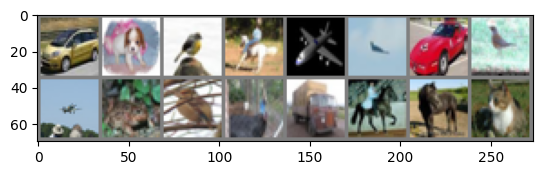

automobile dog   bird  horse airplane airplane automobile bird  airplane frog  bird  bird  truck horse horse cat  


In [11]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

We can define our own model using PyTorch's nn class

Here is a naive implementation of a CNN model:

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Layers
        self.conv1 = nn.Conv2d(3, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # Activations    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net=Net()

**For this tutorial however, we will use pre-defined models from torchvision**

In [13]:
net=torchvision.models.convnext_large()

### Let's inspect the architecutre of this model?

In [14]:
summary(net)

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       9,408
|    |    └─LayerNorm2d: 3-2                  384
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      306,048
|    |    └─CNBlock: 3-4                      306,048
|    |    └─CNBlock: 3-5                      306,048
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  384
|    |    └─Conv2d: 3-7                       295,296
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      1,201,920
|    |    └─CNBlock: 3-9                      1,201,920
|    |    └─CNBlock: 3-10                     1,201,920
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 768
|    |    └─Conv2d: 3-12                      1,180,416
|    └─Seq

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       9,408
|    |    └─LayerNorm2d: 3-2                  384
|    └─Sequential: 2-2                        --
|    |    └─CNBlock: 3-3                      306,048
|    |    └─CNBlock: 3-4                      306,048
|    |    └─CNBlock: 3-5                      306,048
|    └─Sequential: 2-3                        --
|    |    └─LayerNorm2d: 3-6                  384
|    |    └─Conv2d: 3-7                       295,296
|    └─Sequential: 2-4                        --
|    |    └─CNBlock: 3-8                      1,201,920
|    |    └─CNBlock: 3-9                      1,201,920
|    |    └─CNBlock: 3-10                     1,201,920
|    └─Sequential: 2-5                        --
|    |    └─LayerNorm2d: 3-11                 768
|    |    └─Conv2d: 3-12                      1,180,416
|    └─Seq

### 4. Train the network

Now we have our dataset ready and CNN model defined, let's do the following, necessary for training a network
 - Define a Loss function
 - Define an optimizer
 - Define a training loop


**But before going ahead let's select a deivce to trian on and MOVE our model to Device memory**

In [15]:

if torch.cuda.is_available():
    device = 'cuda'
    net.cuda(torch.cuda.current_device());
else:
    print('no GPU seen')
    device = 'cpu'

print(device)


no GPU seen
cpu


### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.
If trianing on GPUs, we can move the object for loss function to GPU memory as well 



In [16]:
criterion = nn.CrossEntropyLoss()
if device == 'cuda':
    criterion.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Let's define a training loop which does the following:
- Read from training dataset images transformed tensors as batches as **inputs**
- load **inputs** to device memory if training on a GPU
- feed **inputs** to CNN and run a forward pass 
- Apply loss function and run a backward propation of loss on each layer
- Optimize weights using the optimizer 
- Print average loss for every 2000 images trained
We iterate over these step for N epochs. 

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
start_timer()
writer = SummaryWriter("logs/min_%d" %(datetime.datetime.now().minute))
for epoch in range(epochs):  # loop over the dataset multiple times
    
    # Train loop
    net.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0],data[1]
        if device == 'cuda':
            inputs=inputs.cuda()
            labels=labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
   
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_acc = accuracy(outputs,labels)
    train_loss = train_loss / len(trainloader.dataset)
    writer.add_scalar("Loss/train", train_loss , epoch)
    writer.add_scalar("Accuracy/train", train_acc , epoch)

    # Validation loop ( we won't backprop and optimize since this step is not training the model)
    net.eval()
    val_loss = 0.0
    for i, data in enumerate(valloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0],data[1]
        if device == 'cuda':
            inputs=inputs.cuda()
            labels=labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() #* data[0].size(0)

    val_acc = accuracy(outputs,labels)
    val_loss = val_loss / len(valloader.dataset)
    writer.add_scalar("Loss/val", val_loss , epoch)
    writer.add_scalar("Accuracy/val", val_acc , epoch)
    print(f'[{epoch + 1}] : Train loss:{train_loss:.3f} | Validation loss:{val_loss:.3f}')

    writer.flush
        


end_timer_and_print('Finished Training')
writer.close()

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
del net